# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Test-Mahalanobis-classifier" data-toc-modified-id="Test-Mahalanobis-classifier-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Test Mahalanobis classifier</a></div><div class="lev2 toc-item"><a href="#Create-dataset" data-toc-modified-id="Create-dataset-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Create dataset</a></div><div class="lev3 toc-item"><a href="#Add-increasing-noise-per-label" data-toc-modified-id="Add-increasing-noise-per-label-111"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Add increasing noise per label</a></div><div class="lev1 toc-item"><a href="#Comparing-covariance-estimators" data-toc-modified-id="Comparing-covariance-estimators-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Comparing covariance estimators</a></div><div class="lev1 toc-item"><a href="#Compare-beginning-and-changepoint" data-toc-modified-id="Compare-beginning-and-changepoint-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Compare beginning and changepoint</a></div><div class="lev2 toc-item"><a href="#No-covariance-recalculation" data-toc-modified-id="No-covariance-recalculation-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>No covariance recalculation</a></div><div class="lev3 toc-item"><a href="#With-Shared-covariance" data-toc-modified-id="With-Shared-covariance-311"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>With Shared covariance</a></div><div class="lev4 toc-item"><a href="#Target-x-Real" data-toc-modified-id="Target-x-Real-3111"><span class="toc-item-num">3.1.1.1&nbsp;&nbsp;</span>Target x Real</a></div><div class="lev3 toc-item"><a href="#With-one-covariance-per-time" data-toc-modified-id="With-one-covariance-per-time-312"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>With one covariance per time</a></div><div class="lev4 toc-item"><a href="#Target-x-Real" data-toc-modified-id="Target-x-Real-3121"><span class="toc-item-num">3.1.2.1&nbsp;&nbsp;</span>Target x Real</a></div><div class="lev4 toc-item"><a href="#Simmetrized" data-toc-modified-id="Simmetrized-3122"><span class="toc-item-num">3.1.2.2&nbsp;&nbsp;</span>Simmetrized</a></div><div class="lev2 toc-item"><a href="#One-covariance-per-split" data-toc-modified-id="One-covariance-per-split-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>One covariance per split</a></div><div class="lev4 toc-item"><a href="#Target-x-Real" data-toc-modified-id="Target-x-Real-3201"><span class="toc-item-num">3.2.0.1&nbsp;&nbsp;</span>Target x Real</a></div><div class="lev4 toc-item"><a href="#Simmetrized" data-toc-modified-id="Simmetrized-3202"><span class="toc-item-num">3.2.0.2&nbsp;&nbsp;</span>Simmetrized</a></div><div class="lev2 toc-item"><a href="#Vectorized" data-toc-modified-id="Vectorized-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Vectorized</a></div>

TODO: Add titles and subtitles to graphs

For the similarity graphs, 
- left means 'before changepoint'
- right is 'after changepoint'

In [1]:
from sklearn.model_selection import GroupShuffleSplit
import sys
sys.path.append('/home/tevo/Documents/UFABC/Spikes')
sys.path.append('/home/tevo/Documents/UFABC/SingleUnit Spike Learning/src/models/')
sys.path.append('/home/tevo/Documents/UFABC/SingleUnit Spike Learning/spikelearn/models')
import os
os.chdir('/home/tevo/Documents/UFABC/Spikes')
from spikeHelper.loadSpike import Rat
import numpy as np
import pandas as pd
from mahalanobis import MahalanobisClassifier

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Test Mahalanobis classifier

## Create dataset

In [396]:
A = np.eye(10)*np.random.randint(13,17,10)
B = A+12*np.random.rand(10,10)
B = B+B.transpose()
mu = np.random.randint(13,17,10)
Xk = np.random.multivariate_normal(mu,B , 7000); yk = np.random.randint(0,7,7000)
precB = np.linalg.inv(B)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Add increasing noise per label

In [404]:
for i in range(7):
    Xk[yk==i] = Xk[yk==i] + 2*i*np.random.rand(*Xk[yk==i].shape)

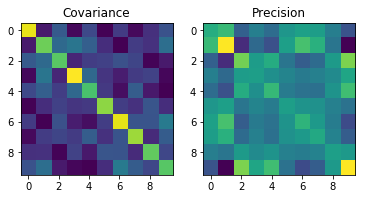

In [407]:
plt.subplot(1,2,1)
plt.imshow(B); plt.title('Covariance')
plt.subplot(1,2,2)
plt.imshow(precB); plt.title('Precision');

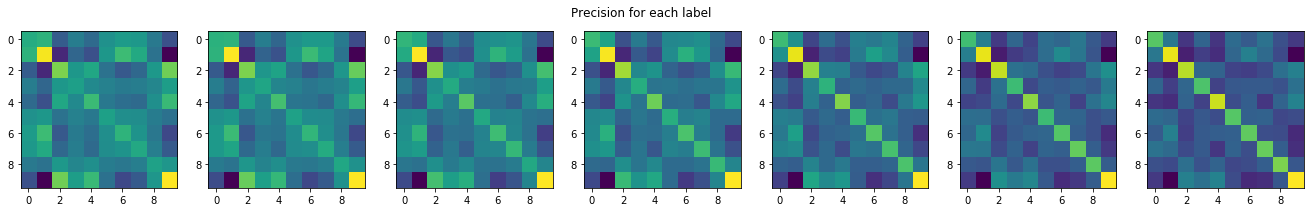

In [411]:
clf = MahalanobisClassifier(classes=np.arange(7), estimator='oas', shared_cov=False, assume_centered=False)
mah = clf.fit(Xk,yk)
plt.figure(figsize=(23,3))
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.imshow(mah.precision_[i])
    plt.suptitle('Precision for each label')

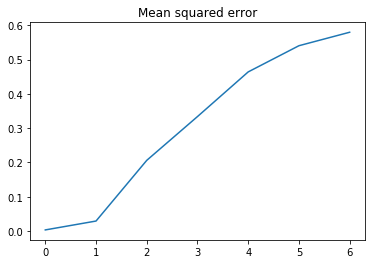

In [414]:
plt.title('Mean squared error')
plt.plot([((precB-mah.precision_[i])**2).sum() for i in range(7)]);

Text(33,0.5,'Target label')

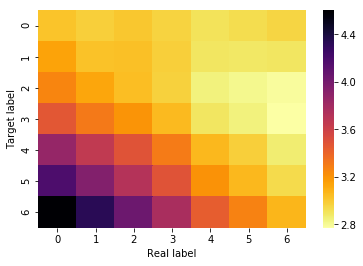

In [410]:
sns.heatmap(np.array([mah.transform(Xk[yk==yi]).mean(axis=0) for yi in range(7)]), cmap='inferno_r')
plt.xlabel('Real label')
plt.ylabel('Target label')

# Comparing covariance estimators

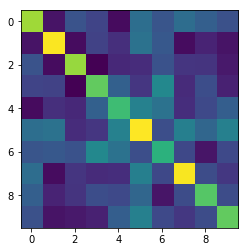

In [123]:
A = np.eye(10)*np.random.randint(13,17,10)
B = A+12*np.random.rand(10,10)
B = B+B.transpose()
mu = np.random.randint(13,17,10)
k = np.random.multivariate_normal(mu,B , 1000)
plt.imshow(B)

In [ ]:
ESTIMATORS = ['OAS', 'LedoitWolf', 'Empirical']

distances = pd.DataFrame()
similarity_matrices = pd.DataFrame()
covariances = pd.DataFrame()


sh = GroupShuffleSplit(50, .5,.5)

for rat_number in [7,8,9,10]:
    r = Rat(rat_number, 20,100)
    r.selecTrials(dict(minDuration=1500, maxDuration=2500))
    r.selecTimes(-500,1500)
    classes = np.unique(r.y)

    for estimator in ESTIMATORS:
        for cov_sharing in [0,1]:
            clf = MahalanobisClassifier(classes=classes, estimator=estimator, shared_cov=cov_sharing)

            for half1_idx, half2_idx in sh.split(r.X, r.y, r.trial):
                dists1 = clf.fit(r.X[half1_idx], r.y[half1_idx]).transform(r.X[half2_idx])
                dists2 = clf.fit(r.X[half2_idx], r.y[half2_idx]).transform(r.X[half1_idx])

                res = pd.DataFrame(np.vstack((dists1,dists2)), 
                                   index=pd.Index(np.hstack((r.y[half2_idx], r.y[half1_idx])),name='Real Time'), 
                                   columns=pd.Index(classes, name='Target time'))
                res['Trial'] = np.hstack( ( r.trial[half2_idx], r.trial[half1_idx] ) )
                res['Covariance Estimator'] = estimator
                res['Covariance Sharing'] = cov_sharing
                res['Rat'] = rat_number
                distances = distances.append(res)

                if cov_sharing:
                    cov = pd.DataFrame({'Covariances': [clf.precision_[0]]},index=pd.Index(['Full'],name='Time')).reset_index()
                else:
                    cov = pd.DataFrame({k:[clf.precision_[k]] for k in clf.precision_.keys()},index=['Covariances'],columns=pd.Index(classes,name='Time')).transpose().reset_index()
                cov['Covariance Estimator'] = estimator
                cov['Covariance Sharing'] = cov_sharing
                cov['Rat'] = rat_number
                covariances = covariances.append(cov)

            sim = distances.reset_index().drop('Trial',axis=1).groupby(['Covariance Estimator','Covariance Sharing']).get_group((estimator, cov_sharing)).groupby('Real Time').agg(np.mean)
            sim['Covariance Estimator'] = estimator
            sim['Covariance Sharing'] = cov_sharing
            sim['Rat'] = rat_number
            similarity_matrices = similarity_matrices.append(sim)

In [ ]:
import pickle
pickle.dump(covariances, open('precisions.pickle', 'wb'))
pickle.dump(similarity_matrices, open('similarity_matrices.pickle', 'wb'))
pickle.dump(distances, open('distances.pickle', 'wb'))


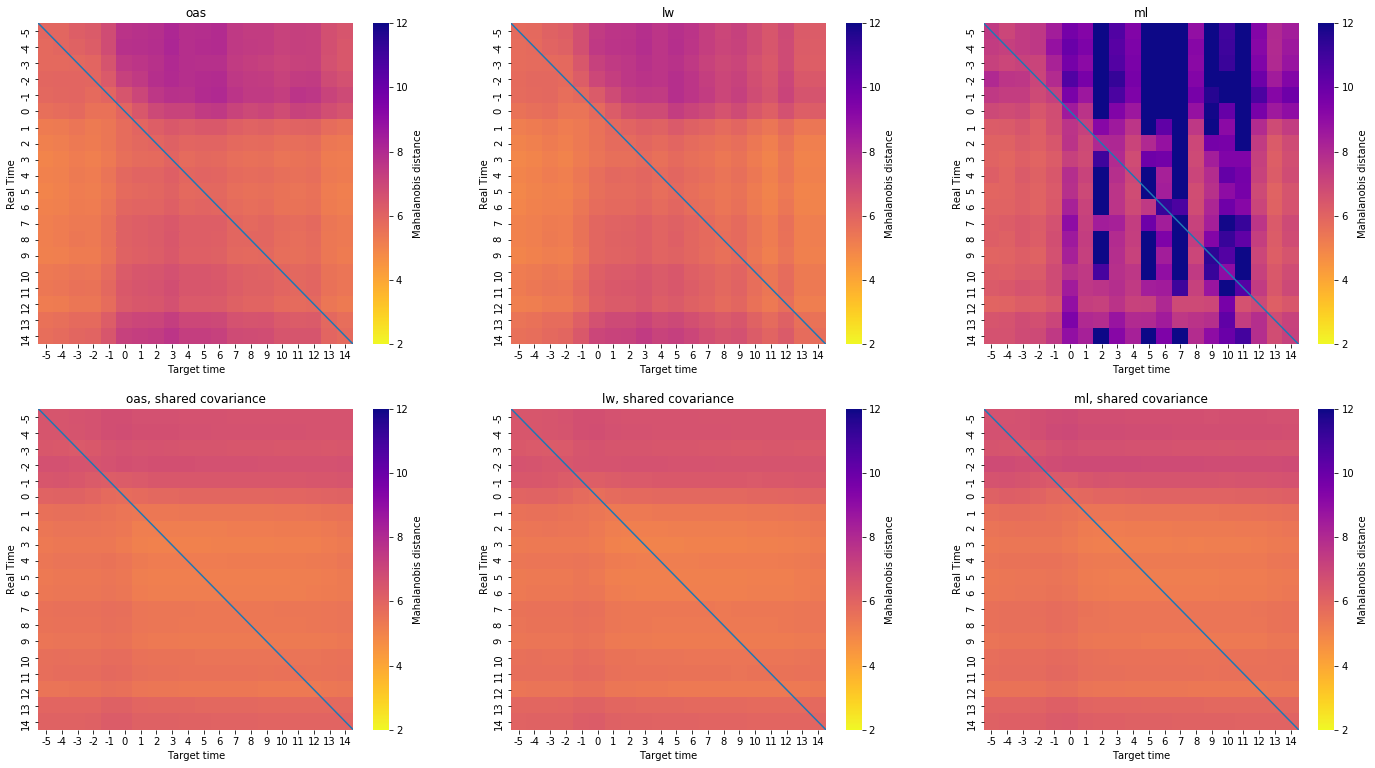

In [201]:
plt.figure(figsize=(24,13))
for i, estimator in enumerate(['oas', 'lw', 'ml']):
    for j, cov_sharing in enumerate([0, 1]):
        plt.subplot(2,3,i+1+3*j)
        sim = all_res[estimator][cov_sharing].reset_index().groupby('Real Time').agg(np.mean)
        sns.heatmap(sim, cmap='plasma_r', cbar_kws={'label': 'Mahalanobis distance'}, vmin=2,vmax=12)
        plt.plot([0,20],[0,20])
        plt.title(estimator + cov_sharing*', shared covariance')

# Compare beginning and changepoint

## No covariance recalculation

### With Shared covariance

In [236]:
CPs = {7:157, 8:314, 9:176, 10:119}
iti_best = {7:400, 8:550, 9:300, 10:400}

classes= np.arange(-25,74)
n_splits = 50

distances = pd.DataFrame()
sim_matrices = pd.DataFrame()
precisions = pd.DataFrame()
for rat_number in [7, 8, 9, 10]:
    ri = Rat(rat_number, 50,20)
    ri.selecTrials(dict(minDuration=1500, maxDuration=2500, trialMax=CPs[rat_number]))
    ri.selecTimes(-500,1500, z_transform='basemean_fullstd')
    
    rf = Rat(rat_number, 50,20)
    rf.selecTrials(dict(minDuration=1500, maxDuration=2500, trialMin=CPs[rat_number], trialMax=iti_best[rat_number]))
    rf.selecTimes(-500,1500, z_transform='basemean_fullstd')
    
    size = min(np.unique(ri.trial).shape[0],np.unique(rf.trial).shape[0])
    s1, s2 = size//2, size - size//2
    
    sh = GroupShuffleSplit(n_splits, s1, s2)
    for label, r in [('Before', ri), ('After', rf)]:
        clf = MahalanobisClassifier(classes=classes, estimator='oas', shared_cov=True, assume_centered=True)
        clf.fit_cov(r.X, r.y)
        for half1_idx, half2_idx in sh.split(r.X, r.y, r.trial):
            
            mean1 = [r.X[half1_idx][r.y[half1_idx]==yi].mean(axis=0) for yi in classes]
            mean2 = [r.X[half2_idx][r.y[half2_idx]==yi].mean(axis=0) for yi in classes]
            
            dists1 = clf.fit(r.X[half1_idx], r.y[half1_idx]).transform(mean2)
            dists2 = clf.fit(r.X[half2_idx], r.y[half2_idx]).transform(mean1)

            res = pd.DataFrame(np.vstack((dists1,dists2)), 
                               index=pd.Index(np.hstack((classes, classes)),name='Real Time'), 
                               columns=pd.Index(classes, name='Target time'))
            #res['Trial'] = np.hstack( ( r.trial[half2_idx], r.trial[half1_idx] ) )
            res['Rat'] = rat_number
            res['Label'] = label
            res['halftrials'] = s1
            distances = distances.append(res)

            cov_inv = pd.DataFrame({k:[clf.precision_[k]] for k in clf.precision_.keys()},index=['Precision'],columns=pd.Index(classes,name='Time')).transpose().reset_index()
            cov_inv['Rat'] = rat_number
            cov_inv['Label'] = label
            precisions = precisions.append(cov_inv)

sim_matrices = distances.reset_index().groupby(['Real Time', 'Rat', 'Label']).agg(np.mean)

def one_sim(rat_number, label):
    return sim_matrices.reset_index().groupby(['Rat', 'Label']).get_group((rat_number, label)).reset_index().drop(['Rat', 'Label','index', 'halftrials'], axis=1).set_index('Real Time')

#### Target x Real

In this case the similarity matrices are already simmetric, because the same covariance matrix is measured used for each calculation

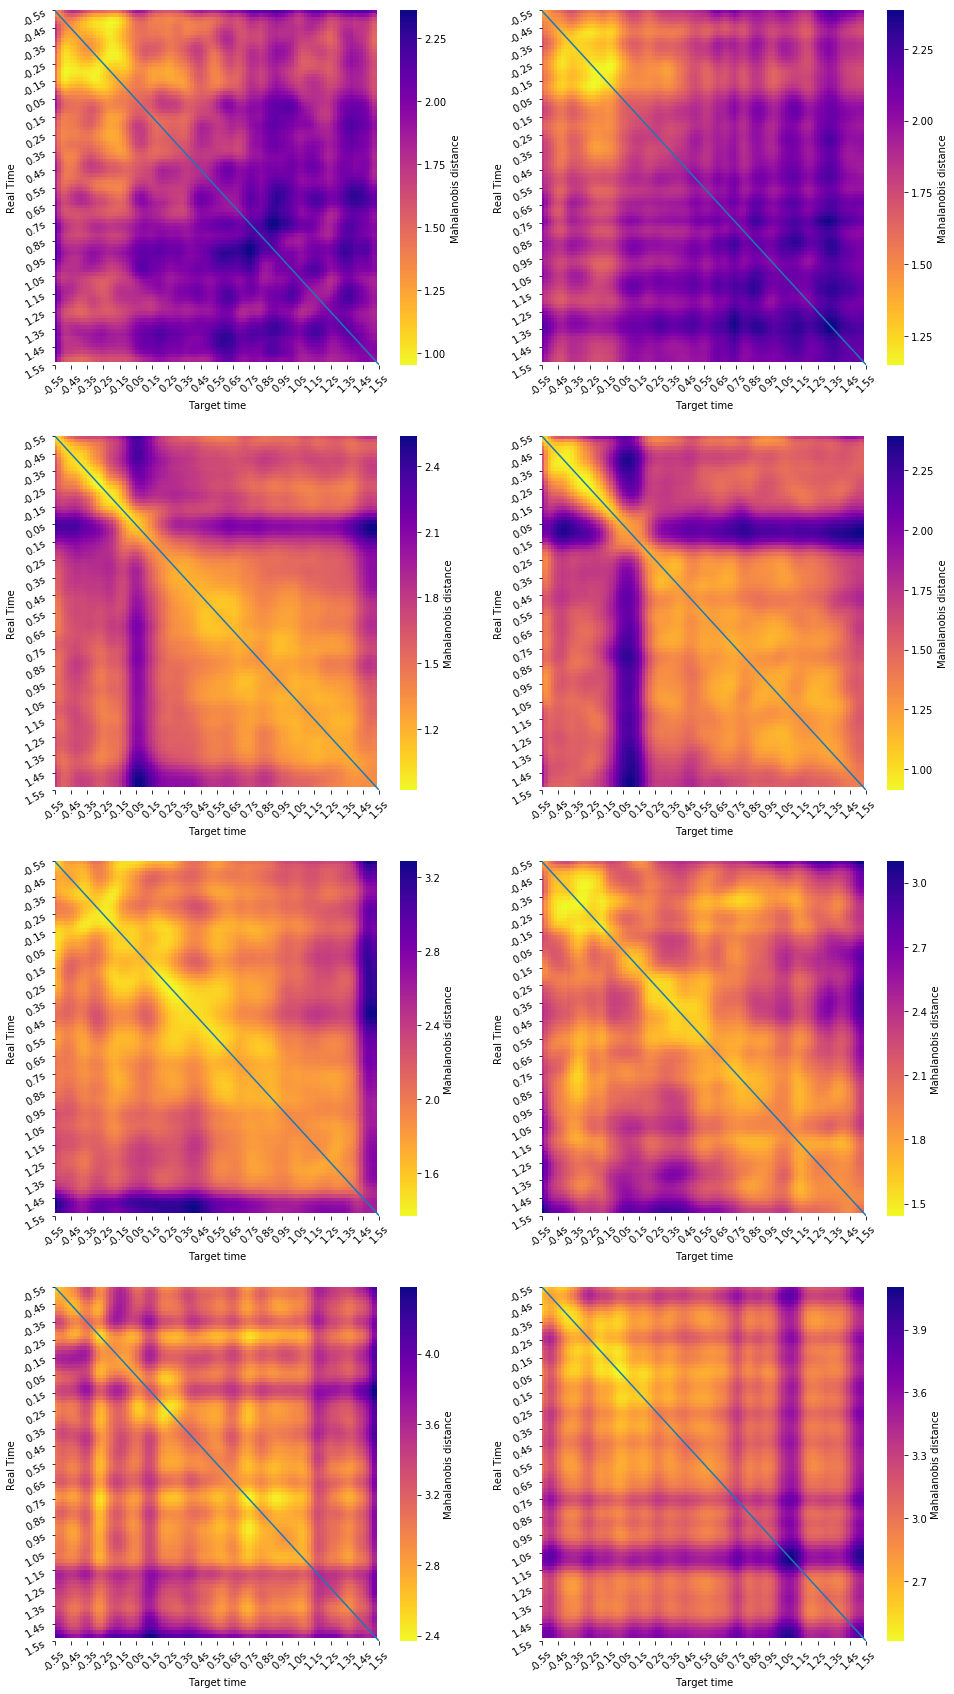

In [237]:
plt.figure(figsize=(16,30))

for j, label in enumerate(['Before', 'After']):
    for i, rat in enumerate([7,8,9,10]):
        ax = plt.subplot(4,2,i*2 + j+1)
        sns.heatmap(one_sim(rat, label), cmap='plasma_r', cbar_kws={'label': 'Mahalanobis distance'},  ax=ax)
        plt.plot([0,100],[0,100]);
        plt.xticks(np.arange(0,101,5),['%.1fs'%((i-25.)/50) for i in range(0, 101, 5)], rotation=45)
        plt.yticks(np.arange(0,101,5),['%.1fs'%((i-25.)/50) for i in range(0, 101, 5)], rotation=30)

### With one covariance per time

In [238]:
CPs = {7:157, 8:314, 9:176, 10:119}
iti_best = {7:400, 8:550, 9:300, 10:400}

classes= np.arange(-25,74)
n_splits = 50

distances = pd.DataFrame()
sim_matrices = pd.DataFrame()
precisions = pd.DataFrame()
for rat_number in [7, 8, 9, 10]:
    ri = Rat(rat_number, 50,20)
    ri.selecTrials(dict(minDuration=1500, maxDuration=2500, trialMax=CPs[rat_number]))
    ri.selecTimes(-500,1500, z_transform='basemean_fullstd')
    
    rf = Rat(rat_number, 50,20)
    rf.selecTrials(dict(minDuration=1500, maxDuration=2500, trialMin=CPs[rat_number], trialMax=iti_best[rat_number]))
    rf.selecTimes(-500,1500, z_transform='basemean_fullstd')
    
    size = min(np.unique(ri.trial).shape[0],np.unique(rf.trial).shape[0])
    s1, s2 = size//2, size - size//2
    
    sh = GroupShuffleSplit(n_splits, s1, s2)
    for label, r in [('Before', ri), ('After', rf)]:
        clf = MahalanobisClassifier(classes=classes, estimator='oas', shared_cov=False, assume_centered=True)
        clf.fit_cov(r.X, r.y)
        for half1_idx, half2_idx in sh.split(r.X, r.y, r.trial):
            
            mean1 = [r.X[half1_idx][r.y[half1_idx]==yi].mean(axis=0) for yi in classes]
            mean2 = [r.X[half2_idx][r.y[half2_idx]==yi].mean(axis=0) for yi in classes]
            
            dists1 = clf.fit(r.X[half1_idx], r.y[half1_idx]).transform(mean2)
            dists2 = clf.fit(r.X[half2_idx], r.y[half2_idx]).transform(mean1)

            res = pd.DataFrame(np.vstack((dists1,dists2)), 
                               index=pd.Index(np.hstack((classes, classes)),name='Real Time'), 
                               columns=pd.Index(classes, name='Target time'))
            #res['Trial'] = np.hstack( ( r.trial[half2_idx], r.trial[half1_idx] ) )
            res['Rat'] = rat_number
            res['Label'] = label
            res['halftrials'] = s1
            distances = distances.append(res)
#             cov_inv = pd.DataFrame({k:[clf.precision_[k]] for k in clf.precision_.keys()},index=['Precision'],columns=pd.Index(classes,name='Time')).transpose().reset_index()
#             cov_inv['Rat'] = rat_number
#             cov_inv['Label'] = label
#             precisions = precisions.append(cov_inv)

sim_matrices = distances.reset_index().groupby(['Real Time', 'Rat', 'Label']).agg(np.mean)

def one_sim(rat_number, label):
    return sim_matrices.reset_index().groupby(['Rat', 'Label']).get_group((rat_number, label)).reset_index().drop(['Rat', 'Label','index', 'halftrials'], axis=1).set_index('Real Time')

#### Target x Real

In this case, the covariance is used according to the *Target* time, which means one covariance was used for each column

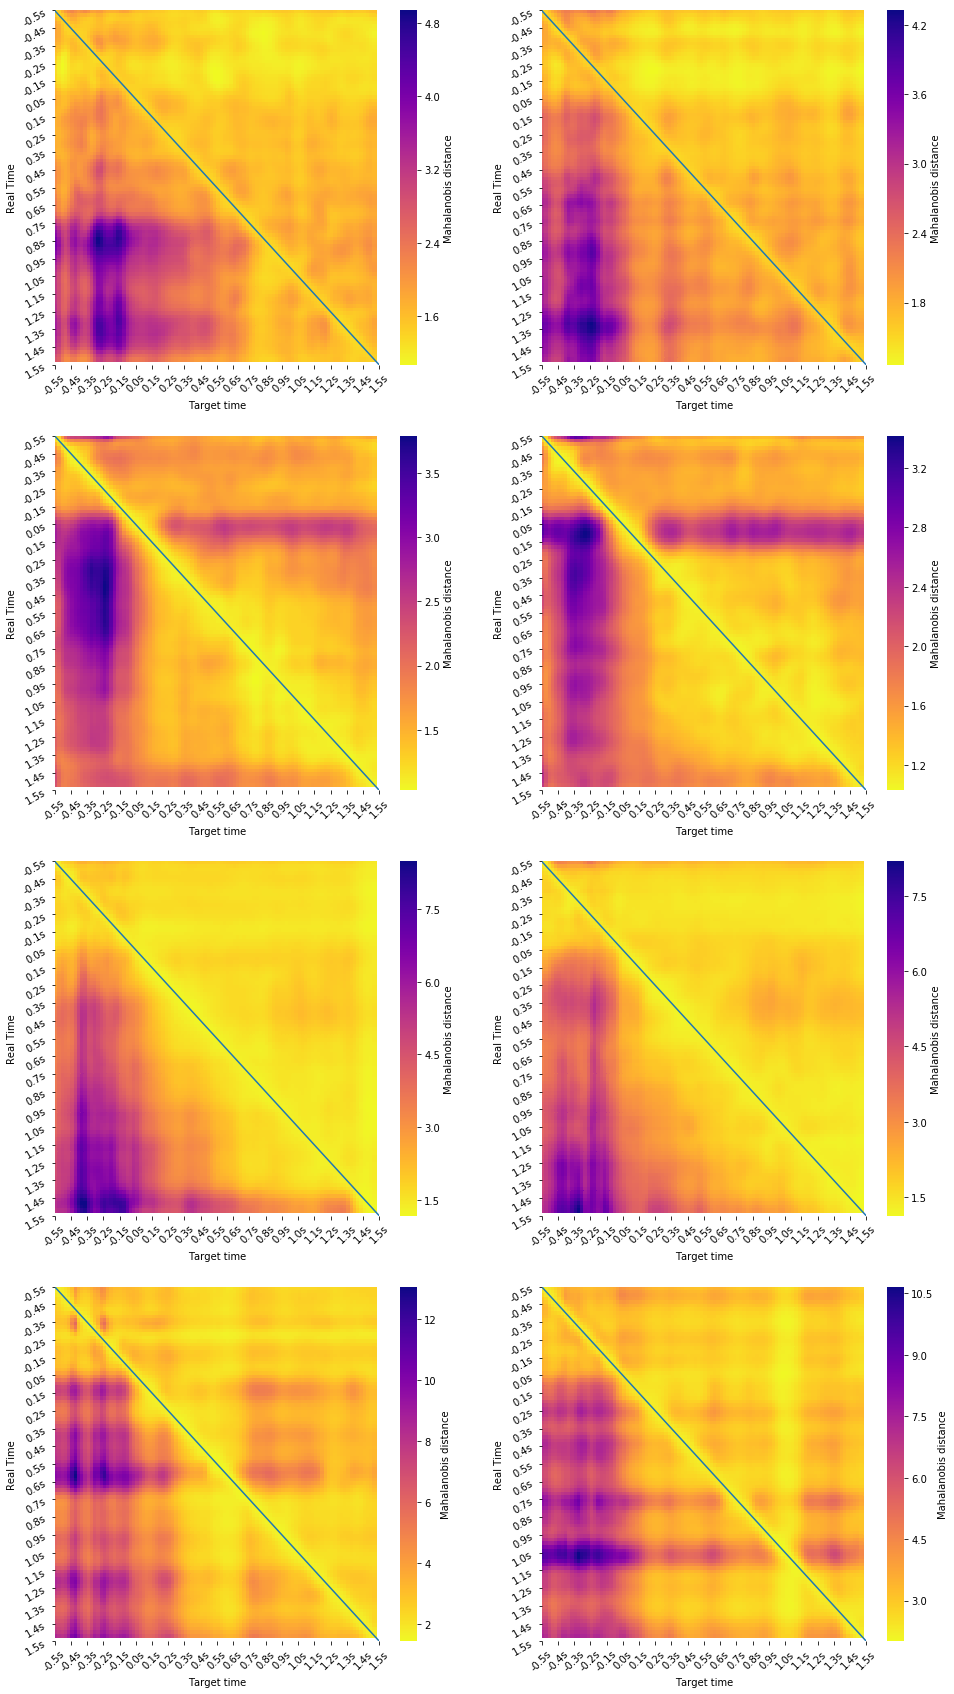

In [239]:
plt.figure(figsize=(16,30))

for j, label in enumerate(['Before', 'After']):
    for i, rat in enumerate([7,8,9,10]):
        ax = plt.subplot(4,2,i*2 + j+1)
        sns.heatmap(one_sim(rat, label), cmap='plasma_r', cbar_kws={'label': 'Mahalanobis distance'},  ax=ax)
        plt.plot([0,100],[0,100]);
        plt.xticks(np.arange(0,101,5),['%.1fs'%((i-25.)/50) for i in range(0, 101, 5)], rotation=45)
        plt.yticks(np.arange(0,101,5),['%.1fs'%((i-25.)/50) for i in range(0, 101, 5)], rotation=30)

#### Simmetrized

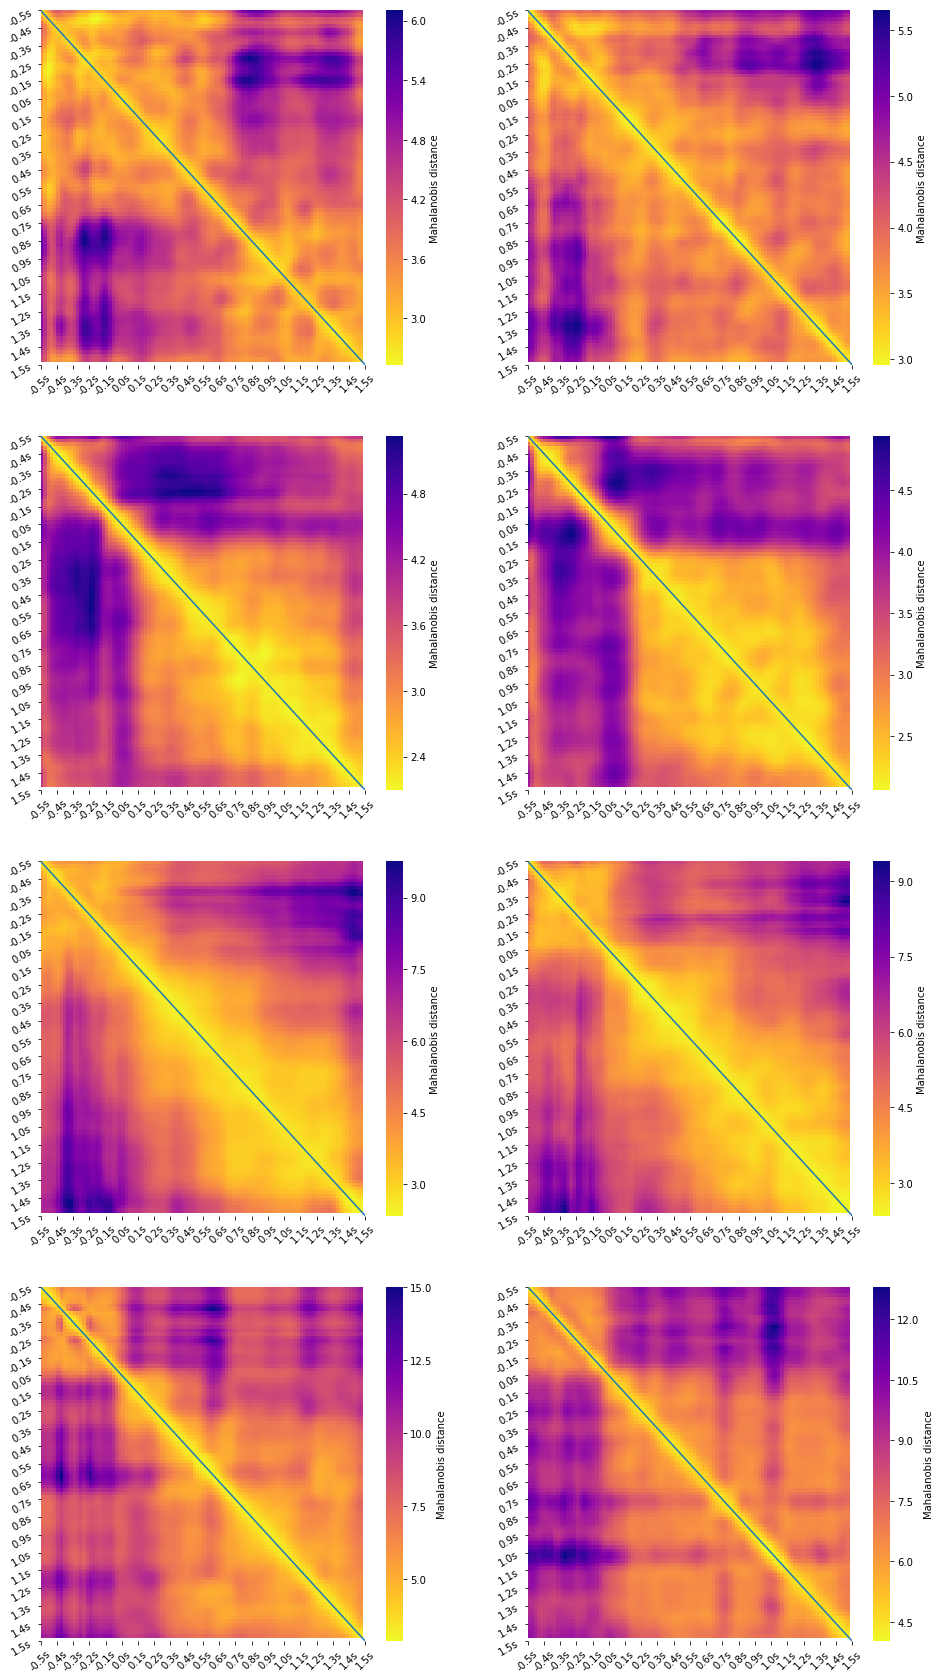

In [240]:
plt.figure(figsize=(16,30))

for j, label in enumerate(['Before', 'After']):
    for i, rat in enumerate([7,8,9,10]):
        ax = plt.subplot(4,2,i*2 + j+1)
        S = one_sim(rat, label).values+ one_sim(rat, label).transpose().values
        sns.heatmap(S, cmap='plasma_r', cbar_kws={'label': 'Mahalanobis distance'}, ax=ax)
        plt.plot([0,100],[0,100]);
        plt.xticks(np.arange(0,101,5),['%.1fs'%((i-25.)/50) for i in range(0, 101, 5)], rotation=45)
        plt.yticks(np.arange(0,101,5),['%.1fs'%((i-25.)/50) for i in range(0, 101, 5)], rotation=30)

## One covariance per split

This results are strange in comparison to the others.

In [241]:
CPs = {7:157, 8:314, 9:176, 10:119}
iti_best = {7:400, 8:550, 9:300, 10:400}

classes= np.arange(-25,74)
n_splits = 50

distances = pd.DataFrame()
sim_matrices = pd.DataFrame()
precisions = pd.DataFrame()
for rat_number in [7, 8, 9, 10]:
    ri = Rat(rat_number, 50,20)
    ri.selecTrials(dict(minDuration=1500, maxDuration=2500, trialMax=CPs[rat_number]))
    ri.selecTimes(-500,1500, z_transform='basemean_fullstd')
    
    rf = Rat(rat_number, 50,20)
    rf.selecTrials(dict(minDuration=1500, maxDuration=2500, trialMin=CPs[rat_number], trialMax=iti_best[rat_number]))
    rf.selecTimes(-500,1500, z_transform='basemean_fullstd')
    
    size = min(np.unique(ri.trial).shape[0],np.unique(rf.trial).shape[0])
    s1, s2 = size//2, size - size//2
    
    sh = GroupShuffleSplit(n_splits, s1, s2)
    for label, r in [('Before', ri), ('After', rf)]:
        clf = MahalanobisClassifier(classes=classes, estimator='oas', shared_cov=False, assume_centered=True)
        for half1_idx, half2_idx in sh.split(r.X, r.y, r.trial):
            X1, X2 = r.X[half1_idx], r.X[half2_idx]
            y1, y2 = r.y[half1_idx], r.y[half2_idx]
            
            mean1 = {yi : X1[y1==yi].mean(axis=0) for yi in classes}
            mean2 = {yi : X2[y2==yi].mean(axis=0) for yi in classes}
            
            meanless1 = np.vstack( X1[y1==yi] - mean1[yi] for yi in classes); c1 = np.vstack( yi*np.ones(np.sum(y1==yi)).reshape(-1,1) for yi in classes)
            meanless2 = np.vstack( X2[y2==yi] - mean2[yi] for yi in classes); c2 = np.vstack( yi*np.ones(np.sum(y2==yi)).reshape(-1,1) for yi in classes)
            
            clf.fit_cov(np.vstack((meanless1, meanless2)), np.vstack((c1,c2)).reshape(-1))
            
            dists1 = clf.fit(r.X[half1_idx], r.y[half1_idx]).transform(mean2)
            dists2 = clf.fit(r.X[half2_idx], r.y[half2_idx]).transform(mean1)

            res = pd.DataFrame(np.vstack((dists1,dists2)), 
                               index=pd.Index(np.hstack((classes, classes)),name='Real Time'), 
                               columns=pd.Index(classes, name='Target time'))
            res['Rat'] = rat_number
            res['Label'] = label
            res['halftrials'] = s1
            distances = distances.append(res)

sim_matrices = distances.reset_index().groupby(['Real Time', 'Rat', 'Label']).agg(np.mean)

def one_sim(rat_number, label):
    return sim_matrices.reset_index().groupby(['Rat', 'Label']).get_group((rat_number, label)).reset_index().drop(['Rat', 'Label','index', 'halftrials'], axis=1).set_index('Real Time')

#### Target x Real

In this case, the covariance is used according to the *Target* time, which means one covariance was used for each column.

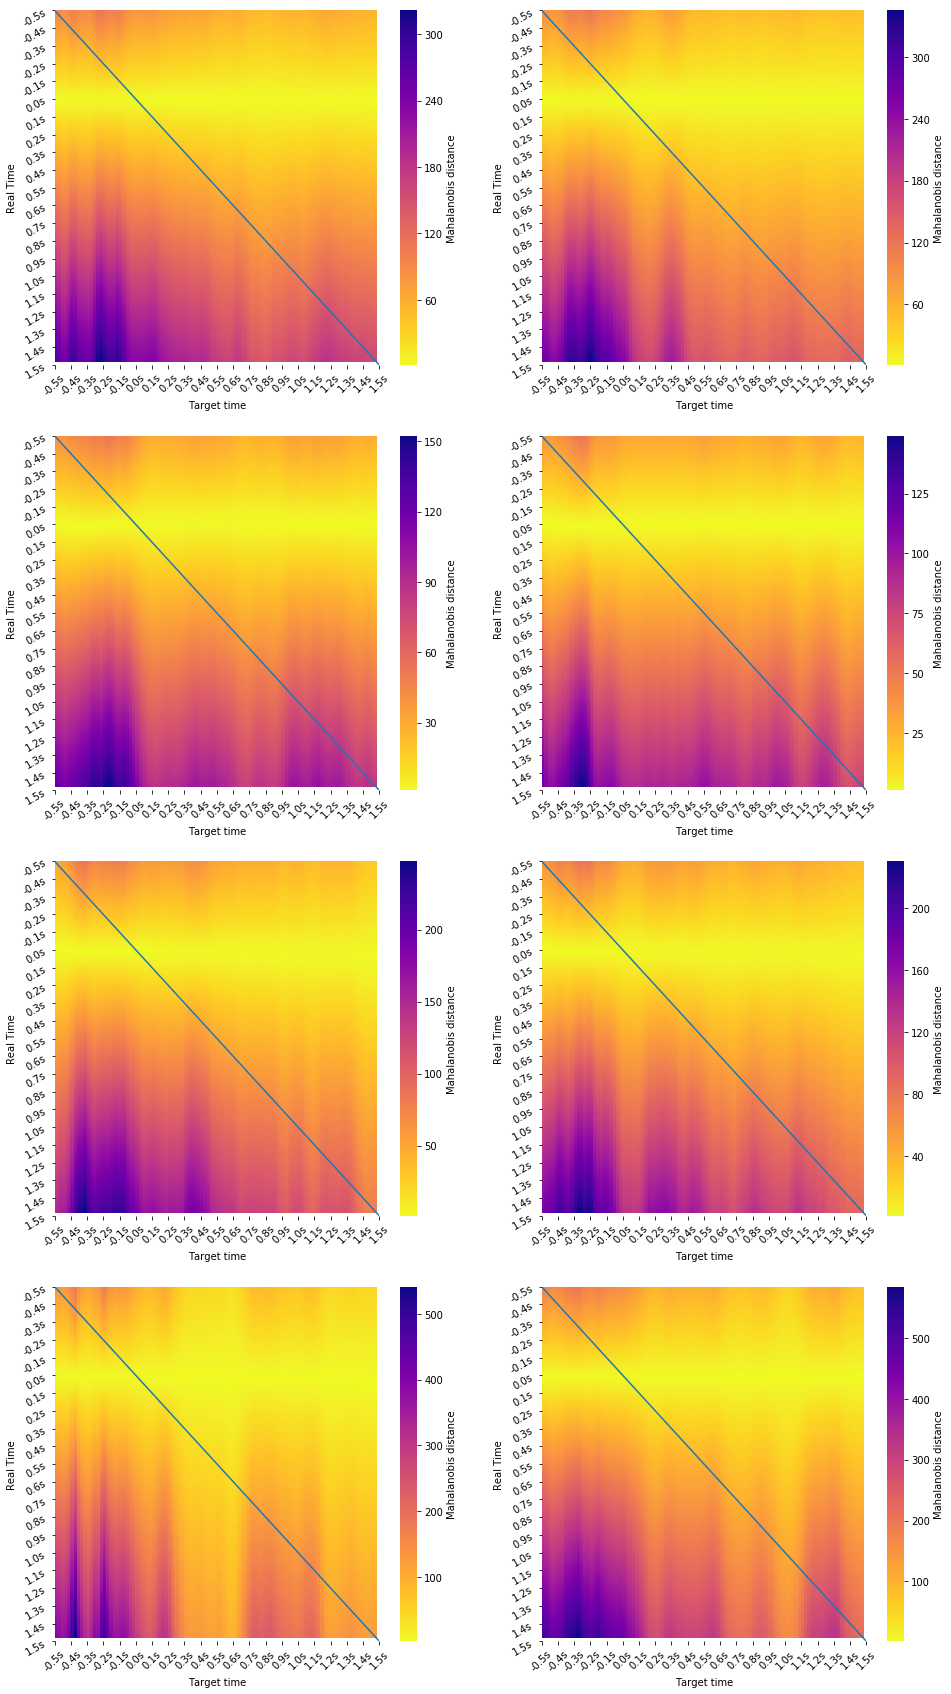

In [242]:
plt.figure(figsize=(16,30))

for j, label in enumerate(['Before', 'After']):
    for i, rat in enumerate([7,8,9,10]):
        ax = plt.subplot(4,2,i*2 + j+1)
        sns.heatmap(one_sim(rat, label), cmap='plasma_r', cbar_kws={'label': 'Mahalanobis distance'},  ax=ax)
        plt.plot([0,100],[0,100]);
        plt.xticks(np.arange(0,101,5),['%.1fs'%((i-25.)/50) for i in range(0, 101, 5)], rotation=45)
        plt.yticks(np.arange(0,101,5),['%.1fs'%((i-25.)/50) for i in range(0, 101, 5)], rotation=30)

#### Simmetrized

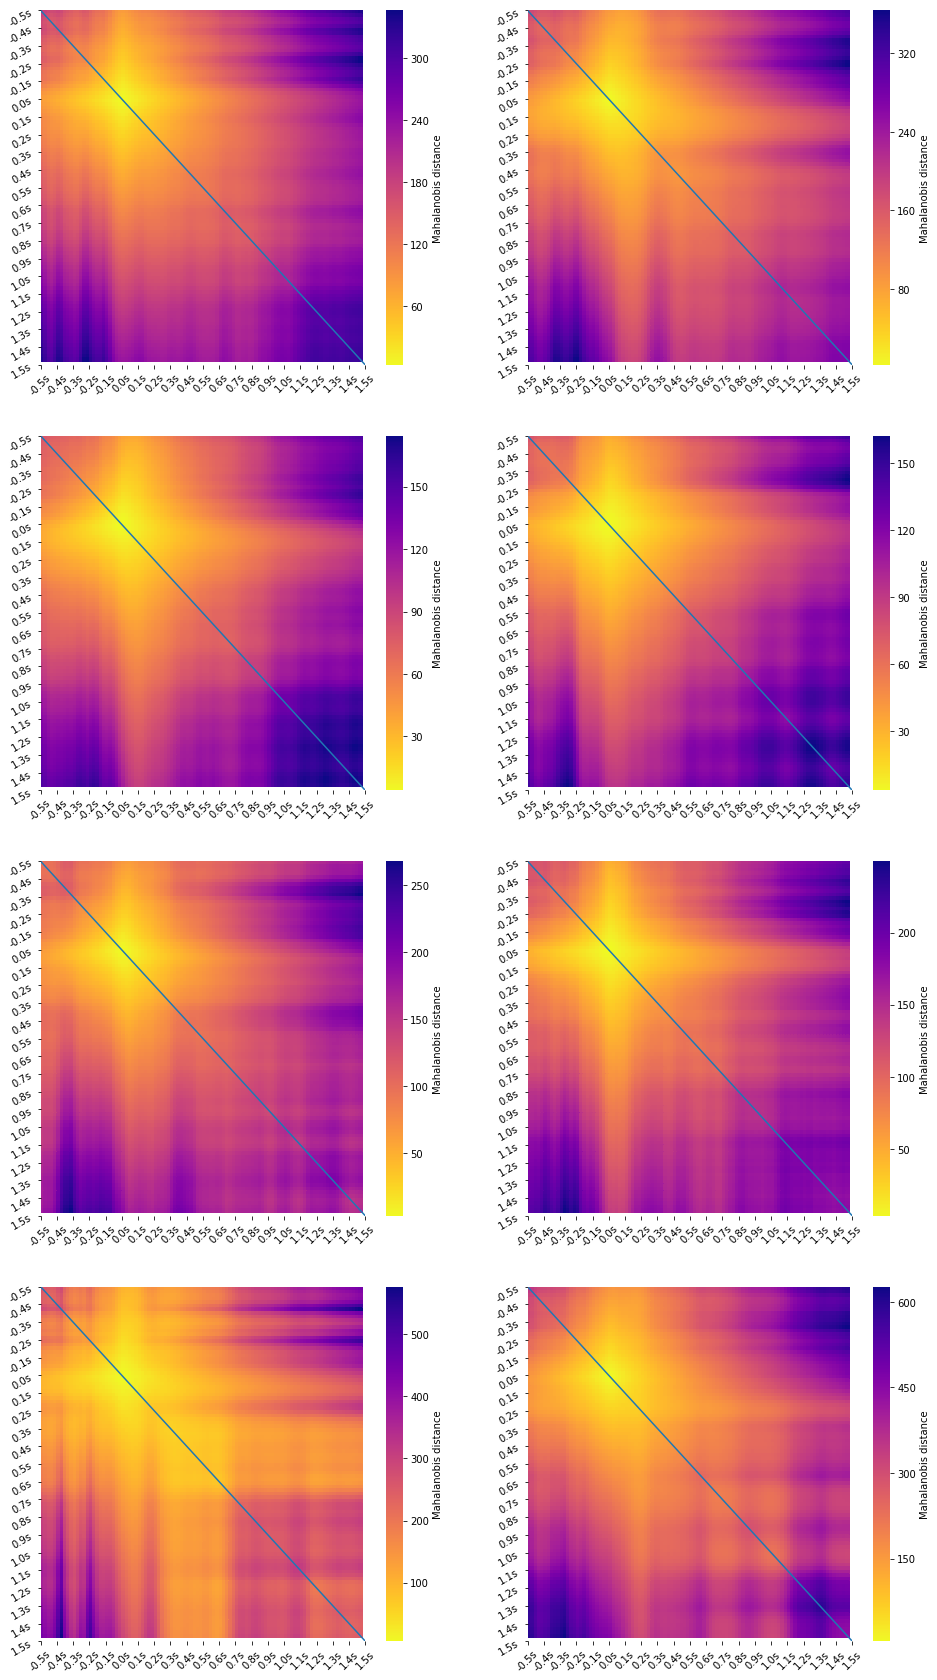

In [243]:
plt.figure(figsize=(16,30))

for j, label in enumerate(['Before', 'After']):
    for i, rat in enumerate([7,8,9,10]):
        ax = plt.subplot(4,2,i*2 + j+1)
        S = one_sim(rat, label).values+ one_sim(rat, label).transpose().values
        sns.heatmap(S, cmap='plasma_r', cbar_kws={'label': 'Mahalanobis distance'}, ax=ax)
        plt.plot([0,100],[0,100]);
        plt.xticks(np.arange(0,101,5),['%.1fs'%((i-25.)/50) for i in range(0, 101, 5)], rotation=45)
        plt.yticks(np.arange(0,101,5),['%.1fs'%((i-25.)/50) for i in range(0, 101, 5)], rotation=30)

## Vectorized

Not implemented yet

In [ ]:
CPs = {7:157, 8:314, 9:176, 10:119}
iti_best = {7:400, 8:550, 9:300, 10:400}

classes= np.arange(-25,74)
n_splits = 1

distances = pd.DataFrame()
sim_matrices = pd.DataFrame()
for rat_number in [7, 8, 9, 10]:
    ri = Rat(rat_number, 100,20)
    ri.selecTrials(dict(minDuration=1500, maxDuration=2500, trialMax=CPs[rat_number]))
    ri.selecTimes(-500,1500, z_transform='basemean_fullstd')
    
    rf = Rat(rat_number, 100,20)
    rf.selecTrials(dict(minDuration=1500, maxDuration=2500, trialMin=CPs[rat_number], trialMax=iti_best[rat_number]))
    rf.selecTimes(-500,1500, z_transform='basemean_fullstd')
    
    size = min(np.unique(ri.trial).shape[0],np.unique(rf.trial).shape[0])
    s1, s2 = size//2, size - size//2
    
    sh = ShuffleSplit(n_splits, s1, s2)
    for label, r in [('Before', ri), ('After', rf)]:
        clf = MahalanobisClassifier(classes=classes, estimator='oas', shared_cov=False, assume_centered=True)
        cubic = r.cubicNeuronTimeTrial()
        for half1_idx, half2_idx in sh.split(np.arange(cubic.shape[2] ) ):
            x1, x2 = cubic[:,:,half1_idx], cubic[:,:,half2_idx]
            
            mean1 = x1.mean(axis=2)
            mean2 = x2.mean(axis=2)
            
            nomean1 = (x1.swapaxes(0,2).swapaxes(1,2) - mean1).swapaxes(2,1).swapaxes(2,0)
            nomean2 = (x2.swapaxes(0,2).swapaxes(1,2) - mean2).swapaxes(2,1).swapaxes(2,0)
            
            X1, y1 = r.X[half1_idx], r.y[half1_idx]
            X2, y2 = r.X[half2_idx], r.y[half2_idx]
            
            mean1 = [X1[y1==yi].mean(axis=0) for yi in classes]
            Xnorm1 = pd.DataFrame(X1, index=y1).reset_index().groupby('index').apply(lambda m: m-np.hstack((0, mean1[m['index'].values[0]+25])))
            
            mean2 = [X2[y2==yi].mean(axis=0) for yi in classes]
            Xnorm2 = pd.DataFrame(X2, index=y2).reset_index().groupby('index').apply(lambda m: m-mean2).values
            
            clf.fit_cov(np.vstack((Xnorm1,Xnorm2)), np.vstack((y1,y2)))
            
            dists1 = clf.fit(X1, y1).transform(mean2)
            dists2 = clf.fit(X2, y2).transform(mean1)

            res = pd.DataFrame(np.vstack((dists1,dists2)), 
                               index=pd.Index(np.hstack((classes, classes)),name='Real Time'), 
                               columns=pd.Index(classes, name='Target time'))
            #res['Trial'] = np.hstack( ( r.trial[half2_idx], r.trial[half1_idx] ) )
            res['Rat'] = rat_number
            res['Label'] = label
            res['halftrials'] = s1
            distances = distances.append(res)

sim_matrices = distances.reset_index().groupby(['Real Time', 'Rat', 'Label']).agg(np.mean)

def one_sim(rat_number, label):
    return sim_matrices.reset_index().groupby(['Rat', 'Label']).get_group((rat_number, label)).reset_index().drop(['Rat', 'Label','index', 'halftrials'], axis=1).set_index('Real Time')